In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.1.1
Scikit-Learn 1.2.2
GPU is available


# todo 
- REMOVE PRINT STATEMENTS
- raggruppare Borrower count >2
- gender capire come raggruppare o eliminare osservazioni?
- gender2 interessante, sono molte più donne che uomini
- PropertyUsageType vedere, strana distribuzione E ANCHE PropertyUnitCount


# how to handle no coborrower ???? 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.stats import percentileofscore

sns.set_context('paper')
sns.set_palette(sns.color_palette("colorblind", as_cmap=True))

In [3]:
dark_blue = "rgb(9, 16, 88)"
light_blue = 'rgb(195, 224, 249)'
dark_yellow = 'rgba(244, 180, 73, 0.3)'
light_yellow = 'rgba(249, 230,130, 1)'
orange = 'rgb(244, 180, 73)'
violetish = 'rgb(89, 100, 217)'

# Import the data

In [4]:
df2021 = pd.read_csv('2021_PUDB_EXPORT_123121.csv')
df2021.shape

(63890, 56)

In [5]:
df2020 = pd.read_csv('2020_PUDB_EXPORT_123120.csv')
df2020.shape

(83106, 56)

In [6]:
df2019 = pd.read_csv('2019_PUDB_EXPORT_123119.csv')
df2019.shape

(89767, 56)

In [7]:
data= pd.concat([df2021, df2020, df2019], axis=0, ignore_index=True)

In [8]:
#data.columns

In [9]:
data['IndexSourceType'].unique()

array([99])

## Checking data integrity

In [10]:
data.Year.unique()

array([2021, 2020, 2019])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236763 entries, 0 to 236762
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Year                             236763 non-null  int64  
 1   LoanCharacteristicsID            236763 non-null  int64  
 2   Bank                             236763 non-null  object 
 3   FIPSStateNumericCode             236763 non-null  int64  
 4   FIPSCountyCode                   236763 non-null  int64  
 5   CoreBasedStatisticalAreaCode     236763 non-null  int64  
 6   CensusTractIdentifier            236763 non-null  float64
 7   CensusTractMinorityRatioPercent  236763 non-null  float64
 8   CensusTractMedFamIncomeAmount    236763 non-null  int64  
 9   LocalAreaMedianIncomeAmount      236763 non-null  int64  
 10  TotalMonthlyIncomeAmount         236763 non-null  int64  
 11  HUDMedianIncomeAmount            236763 non-null  int64  
 12  Lo

# Interest Rate analysis

In [12]:
print(data.NoteRatePercent.describe())

count    236763.000000
mean          3.370611
std           0.651439
min           1.625000
25%           2.875000
50%           3.250000
75%           3.750000
max           6.250000
Name: NoteRatePercent, dtype: float64


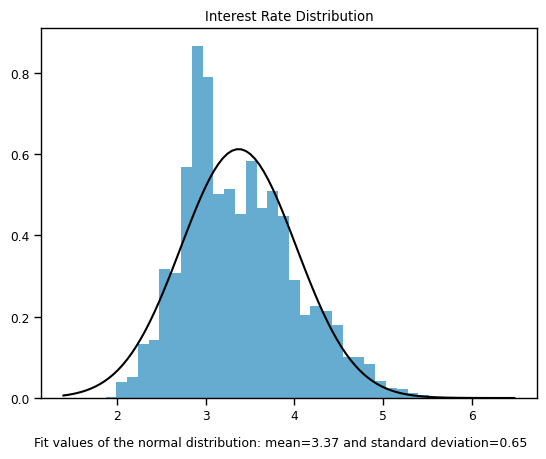

In [13]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu, std = norm.fit(data.NoteRatePercent) 
  
# Plot the histogram.
plt.hist(data.NoteRatePercent, bins=38, density=True, alpha=0.6)#, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth= 1.5)
title = "Interest Rate Distribution"
footnote = "Fit values of the normal distribution: mean={:.2f} and standard deviation={:.2f}".format(mu, std)
plt.title(title)
plt.figtext(0.5, 0.01, footnote, ha="center", fontsize=9)

plt.savefig('IntRate_Distribution.png')
plt.show();

## Data Cleaning

1. remove redundant columns
2. clean up numerical codes that indicate "non applicable" or "unknown"

In [14]:
pd.testing.assert_series_equal(data['LoanAcquisitionDate'], data['Year'], check_names=False)

In [15]:
pd.testing.assert_series_equal(data['LoanAmortizationMaxTermMonths'], data['ScheduledTotalPaymentCount'], check_names=False)

### Removing Redundant or Non-Informative Columns

In [16]:
data.drop(['LoanAcquisitionDate','LoanAmortizationMaxTermMonths','ProductCategoryName', 'LienPriorityType', 
           'IndexSourceType', 'MarginRatePercent', 'LoanCharacteristicsID']
          , inplace=True, axis=1)

### Look into columns that are `object` dtypes.

In [17]:
data['PrepaymentPenaltyExpirationDate'].unique()

array(['9999-12-31'], dtype=object)

In [18]:
data.drop(['PrepaymentPenaltyExpirationDate'], inplace=True, axis=1)

The data description tells us that this column reports "Date when prepayment penalty ends; report 9999-12- 31 if not applicable", hence we can exclude this column since it's always non applicable.

In [19]:
data['Bank'].unique()

array(['Boston', 'Chicago', 'Cincinnati', 'Dallas', 'Des Moines',
       'Indianapolis', 'New York', 'Pittsburgh', 'San Francisco',
       'Topeka'], dtype=object)

We can keep this as a categorical variable.

In [20]:
data['PropertyType'].unique()

array(['PT01', 'PT06', 'PT04', 'PT12', 'PT09', 'PT07', 'PT10', 'PT03',
       'PT11', 'PT02', 'PT05', 'PT08'], dtype=object)

In [21]:
data['PropertyType'] = data['PropertyType'].apply(lambda x: int(x[2:]))
sorted(data['PropertyType'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Minority status analysis


We first need to create a dummy indicating whether a person comes from a minority group or not. We have two different variables that we can use, so we explore them more in detail.

**Variable 1: `Borrower1EthnicityType`**

- 1=Hispanic or Latino; 
- 2=Not Hispanic or Latino; 
- 3=Information not provided; 
- 4=Not applicable (First or primary borrower is an institution, corporation or partnership)




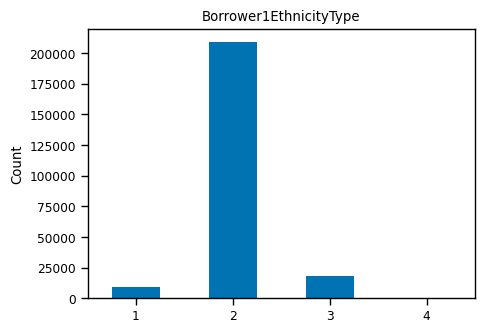

In [22]:
data['Borrower1EthnicityType'].value_counts().sort_index().plot(kind='bar', figsize=(5,3.5),
                                                    title='Borrower1EthnicityType', xlabel='', ylabel='Count', rot=0);
plt.savefig('Borrower1EthnicityType_Dist')

In [23]:
data['Borrower1EthnicityType'].value_counts().sort_index()

Borrower1EthnicityType
1      9336
2    209269
3     18108
4        50
Name: count, dtype: int64

We can see that the distribution is not balanced, with a vast majority of loan applicant belonging to the category "Not Hispanic or Latino" (2), and too many applicants in the "Hispanic or Latino" category (1), which would be our minority. 
We now investigate our second option. 

**Variable 2: `Borrower1Race1Type`**

- 1=American Indian or Alaska Native, 
- 2=Asian, 
- 3=Black or African American, 
- 4=Native Hawaiian or other Pacific Islander, 
- 5=White, 
- 6=Information not provided by Borrower, 
- 7=Not Applicable (First or primary borrower is an institution, corporation or partnership)

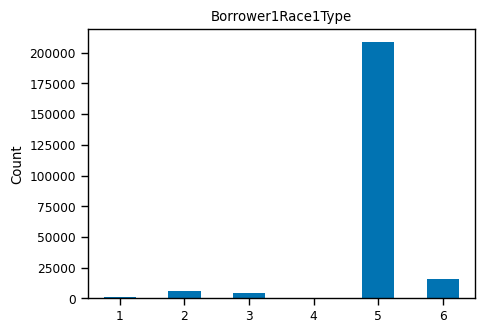

In [24]:
data['Borrower1Race1Type'].value_counts().sort_index().plot(kind='bar', figsize=(5,3.5),
                                                    title='Borrower1Race1Type', xlabel='', ylabel='Count', rot=0);
plt.savefig('Race_Dist')

In [25]:
data['Borrower1Race1Type'].value_counts().sort_index()

Borrower1Race1Type
1      1375
2      6017
3      4303
4       230
5    208835
6     16003
Name: count, dtype: int64

The distribution looks similar to the other one, taking into account that categories 1,2,3 are probably grouped into "Hispanic or Latino", and only "White" individuals are classified as "Not Hispanic or Latino".

In [26]:
counts_race = pd.DataFrame(data['Borrower1Race1Type'].value_counts().sort_index()).reset_index()
mapping={'1':'Min','2':'Min','3':'Min','4':'Min','5':'White','6':'Missing','7':'Missing'}
counts_race['grouped'] = counts_race.Borrower1Race1Type.astype('str').map(mapping)
counts = counts_race.groupby('grouped')['count'].sum()
counts

grouped
Min         11925
Missing     16003
White      208835
Name: count, dtype: int64

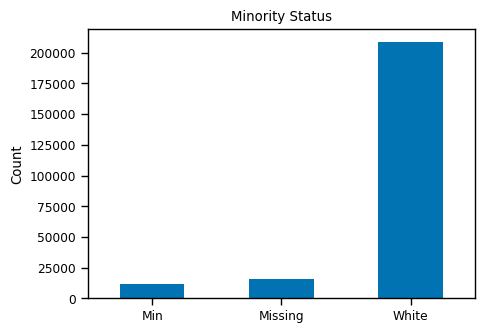

In [27]:
counts.plot(kind='bar', figsize=(5,3.5), title='Minority Status', xlabel='', ylabel='Count', rot=0);
plt.savefig('Minority_Dummy_Dist.png')

Since this classification presents a higher number of minority observations and less (in fact, 0) "Not Applicable" data points, we will keep this classification to determine whether a loan applicant is from a minority or not. 
We therefore pass this mapping down to the dataframe. 

It must be noted that the dataset is clearly unbalanced since we have a vast majority of observations that belong to the non-minority category, and this will need to be taken into account during the analysis.

We will drop the Ethnicity information since we can consider it redundant as we don't have any additional information on how it was recorded, but we will keep the Race varibale in order to inspect possible differences among different ethinc groups among non-White individuals. 

In [28]:
counts_race = pd.DataFrame(data['Borrower1Race1Type'].value_counts().sort_index()).reset_index()
mapping={'1':'Minority','2':'Minority','3':'Minority','4':'Minority','5':'White','6':'Missing','7':'Missing'}
counts_race['grouped'] = counts_race.Borrower1Race1Type.astype('str').map(mapping)
counts = counts_race.groupby('grouped')['count'].sum()
counts

grouped
Minority     11925
Missing      16003
White       208835
Name: count, dtype: int64

In [29]:
data['Borrower1Race1Type'].value_counts()/1000

Borrower1Race1Type
5    208.835
6     16.003
2      6.017
3      4.303
1      1.375
4      0.230
Name: count, dtype: float64

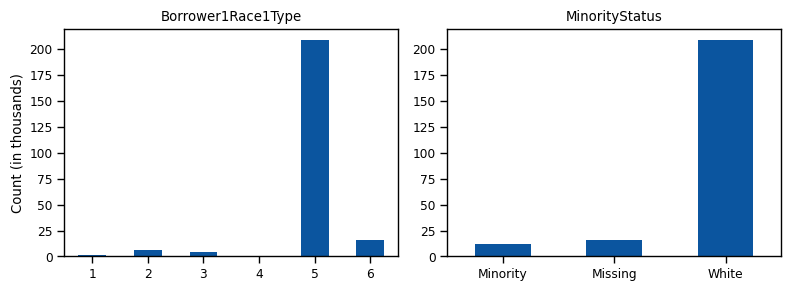

In [30]:
#TO EXPORT PLOT

# Set the color palette to green
sns.set_palette('Blues_r')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# fix ordine di grandezza
race1 = data['Borrower1Race1Type'].value_counts()/1000
counts = counts/1000

# Plot the bar charts
race1.sort_index().plot(
                kind='bar', ax=axes[0], title='Borrower1Race1Type', xlabel='', ylabel='Count (in thousands)', rot=0)
counts.plot(kind='bar', ax=axes[1], title='MinorityStatus', xlabel='', ylabel='', rot=0)
#fig.suptitle('Side-by-Side Bar Plots', fontsize=16)
plt.tight_layout()

# Show the plots
plt.savefig('MinorityAnalysis.png')
plt.show()

In [31]:
data.drop(['Borrower1EthnicityType'], inplace=True, axis=1)
data['Minority'] = data.Borrower1Race1Type.astype('str').map(mapping).astype('category')
data['Minority']

0         Missing
1           White
2           White
3           White
4           White
           ...   
236758      White
236759      White
236760      White
236761      White
236762      White
Name: Minority, Length: 236763, dtype: category
Categories (3, object): ['Minority', 'Missing', 'White']

### Analysis of other race variables

The dataset presents 4 other variables indicating other ethnic traits of borrowers, such as `Borrower1Race2Type`, `Borrower1Race3Type`, etc. 
We will now inspect their values. 

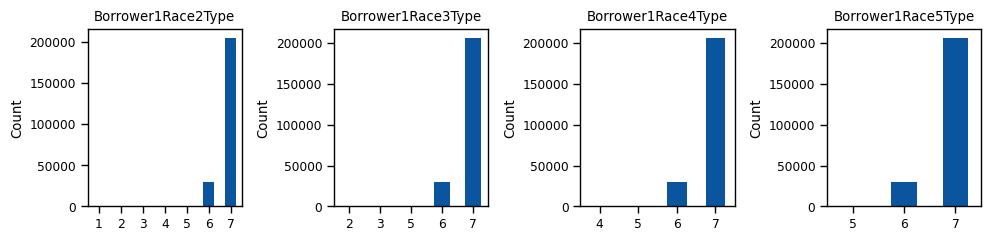

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(10,2.5), tight_layout=True)
for i in range(4):
    data['Borrower1Race'+str(i+2)+'Type'].value_counts().sort_index().plot(kind='bar', ax=ax[i],
                                        title='Borrower1Race'+str(i+2)+'Type', xlabel='', ylabel='Count', rot=0);

As we can see, these variables are not meaningful for our analysis, since most observations fall under the categories:
5=White; 6=Information not provided; 7=Not Applicable (borrower is an institution, corporation or partnership). 
Hence, we can exclude these variables from our data.

In [33]:
data.drop(['Borrower1Race2Type', 'Borrower1Race3Type', 'Borrower1Race4Type', 'Borrower1Race5Type'], 
          inplace=True, axis=1)

# BORROWER 2 RACE


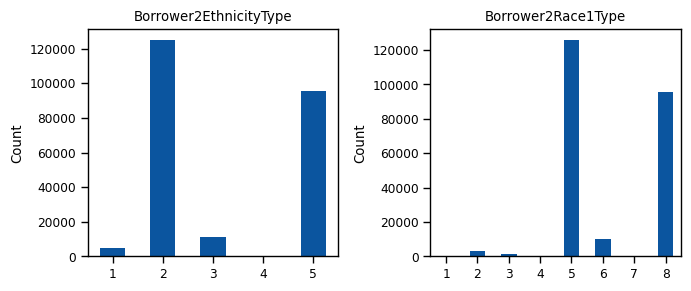

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), tight_layout=True)

data['Borrower2EthnicityType'].value_counts().sort_index().plot(kind='bar',title='Borrower2EthnicityType', xlabel='', ylabel='Count', rot=0, ax=ax[0]);
data['Borrower2Race1Type'].value_counts().sort_index().plot(kind='bar',title='Borrower2Race1Type', xlabel='', ylabel='Count', rot=0, ax=ax[1]);

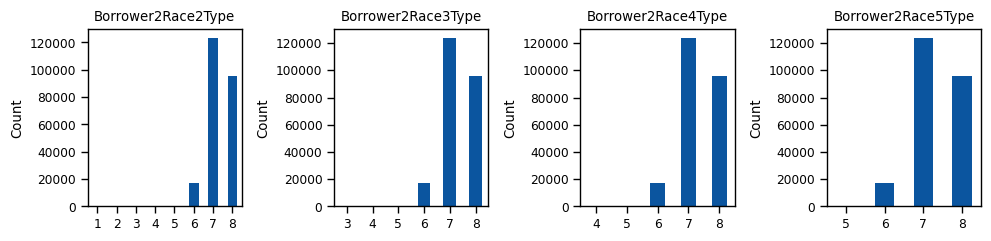

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(10,2.5), tight_layout=True)
for i in range(4):
    data['Borrower2Race'+str(i+2)+'Type'].value_counts().sort_index().plot(kind='bar', ax=ax[i],
                                        title='Borrower2Race'+str(i+2)+'Type', xlabel='', ylabel='Count', rot=0);

These variables show once again a majority of white applicants (category 2 and 5 respectively), and a consistent number of loans for which there is no co-borrower (category 5 and 8 respectively). However, we can find the same patterns as before, that is we can hypothesize that all races other than white are classified as "Hispanic or Latino" ethnicity (category 1) and other race variables do not provide any additional information. 
We will therefore proceed in the same way by grouping minorities into one category and dropping other variables.

In [36]:
mapping={'1':'Min','2':'Min','3':'Min','4':'Min','5':'White','6':'Missing','7':'Missing', '8':'Missing'}

data['Borrower2Minority'] = data.Borrower2Race1Type.astype('str').map(mapping).astype('category')

data.drop(['Borrower2EthnicityType', 'Borrower2Race2Type', 'Borrower2Race3Type', 'Borrower2Race4Type', 
           'Borrower2Race5Type'], inplace=True, axis=1)

In [37]:
(data['Borrower2Minority']=='Missing').sum()

105683

# Mutual Info Classifier - make regressor


Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)


In [38]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores, namevar='Interest Rate'):
    f, ax = plt.subplots(figsize=(8, 12))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores: " + str(namevar))

In [39]:
X_temp = data.copy()
y_temp = X_temp.pop('NoteRatePercent')
mi_scores = make_mi_scores(X_temp, y_temp)

/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated

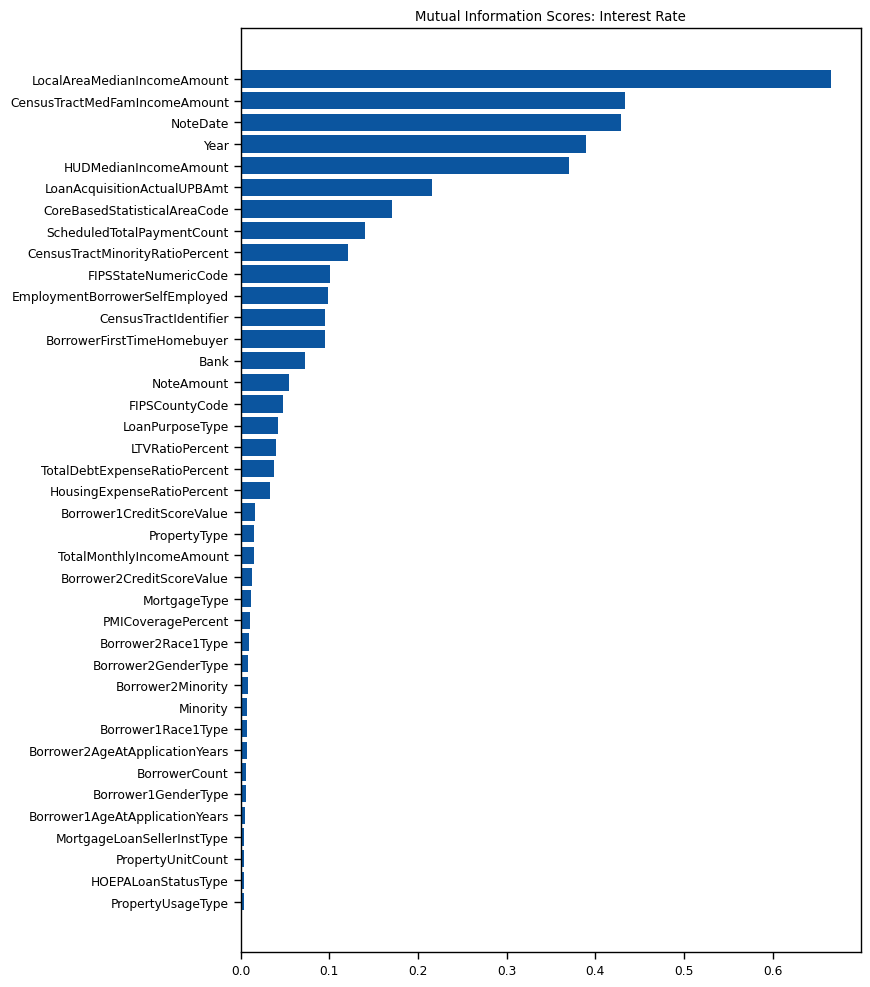

In [40]:
plot_mi_scores(mi_scores)

As we can see, the last features have such low scores that we will **probably** want to exclude them from our analysis since they don't seem to have a relationship with our target variable `NoteRatePercent`, on the contrary, they appear to be independent.

# Substituting codes for missing values

We first drop observations with null credit score for the main borrower.
Then, we assess the proportion of missing values on the dataset and decide whether to drop them or fill with other more meaningful codes. 


In [39]:
data.drop(data.loc[data['Borrower1CreditScoreValue']==9].index, inplace=True)

In [40]:
print(f'The percentage of missing values in Borrower1AgeAtApplicationYears is '\
      f'{(100*(((data.Borrower1AgeAtApplicationYears==999).sum()+(data.Borrower1AgeAtApplicationYears==998).sum())/len(data)))}%.')

print(f'The percentage of missing values in Borrower2AgeAtApplicationYears is '\
      f'{(100*(((data.Borrower2AgeAtApplicationYears==999).sum()+(data.Borrower2AgeAtApplicationYears==998).sum())/len(data)))}%.')

print(f'The percentage of missing values in CoreBasedStatisticalAreaCode is '\
      f'{(100*(data.CoreBasedStatisticalAreaCode ==99999).sum()/len(data))}%.')

The percentage of missing values in Borrower1AgeAtApplicationYears is 0.0029616341451031494%.
The percentage of missing values in Borrower2AgeAtApplicationYears is 40.41615190644621%.
The percentage of missing values in CoreBasedStatisticalAreaCode is 16.67653878048368%.


In [41]:
data.drop(data.loc[data['Borrower1AgeAtApplicationYears']==999].index, inplace=True)
data.drop(data.loc[data['Borrower1AgeAtApplicationYears']==998].index, inplace=True)

# replace missing value codes 
data['Borrower2AgeAtApplicationYears']=data['Borrower2AgeAtApplicationYears'].apply(lambda x: 0 if x in (999,998) else x)
data['CoreBasedStatisticalAreaCode']=data['CoreBasedStatisticalAreaCode'].apply(lambda x: 'Missing' if x==99999 else x)

##### Low percentage of missing for Age1, we can keep it as missing or exclude. 

We will drop observations with missing Credit Score for the main borrower since that is our variable of interest. 

In [42]:
# CREDIT SCORES
data.drop(data.loc[data['Borrower1CreditScoreValue']==9].index, inplace=True) # dropping observations with null credit score

data['Borrower2Dummy']=data['Borrower2CreditScoreValue'].apply(lambda x: 0 if x==9 else 1)

In [43]:
(data['Borrower2CreditScoreValue']==9).sum() / len(data)

0.4053412538237945

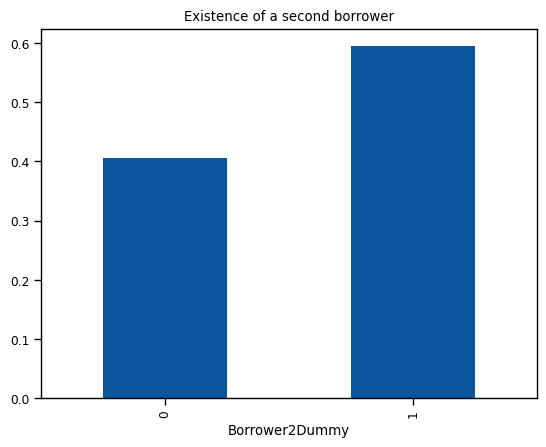

In [44]:
data['Borrower2Dummy'].value_counts(normalize=True).sort_index().plot(kind="bar").set_title('Existence of a second borrower');

# EXPLORATORY ANALYSIS: CATEGORICAL VS NUMERICAL VARIABLES



In [45]:
categorical = data[['Bank','LoanPurposeType','MortgageType','MortgageLoanSellerInstType','BorrowerCount',
                    'BorrowerFirstTimeHomebuyer','Borrower1GenderType', 'Borrower2GenderType','PropertyUsageType',
                    'EmploymentBorrowerSelfEmployed','PropertyType', 'HOEPALoanStatusType', 'PropertyUnitCount', 
                    'Borrower1Race1Type', 'Borrower2Minority', 'Borrower2Race1Type', 'CensusTractIdentifier',
                    'CoreBasedStatisticalAreaCode', 'FIPSCountyCode', 'FIPSStateNumericCode', 'Minority']]
len(categorical.columns)

21

## Numerical Variables

In [46]:
numerical = data[['Year','NoteRatePercent','CensusTractMinorityRatioPercent','CensusTractMedFamIncomeAmount',
                  'LocalAreaMedianIncomeAmount', 'TotalMonthlyIncomeAmount','HUDMedianIncomeAmount',
                  'LoanAcquisitionActualUPBAmt', 'LTVRatioPercent','ScheduledTotalPaymentCount',
                  'Borrower1AgeAtApplicationYears', 'Borrower2AgeAtApplicationYears','HousingExpenseRatioPercent',
                  'TotalDebtExpenseRatioPercent','PMICoveragePercent', 'Borrower1CreditScoreValue', 
                  'Borrower2CreditScoreValue', 'NoteDate', 'NoteAmount']]
len(numerical.columns)

19

In [47]:
set(data.columns) - set(categorical.columns) - set(numerical.columns)

{'Borrower2Dummy'}

In [48]:
# rename
numerical.rename(columns={
    'NoteRatePercent':'InterestRate',
    'CensusTractMinorityRatioPercent':'MinorityRatio',
    'CensusTractMedFamIncomeAmount':'CensusTractMedFamIncome', 
    'LocalAreaMedianIncomeAmount':'LocalAreaMedianIncome',
    'TotalMonthlyIncomeAmount':'MonthlyIncome',
    'HUDMedianIncomeAmount':'HUDMedIncome',
    'LoanAcquisitionActualUPBAmt':'UPB',
    'LTVRatioPercent':'LTV',
    'ScheduledTotalPaymentCount':'PaymentCount',
    'Borrower1AgeAtApplicationYears':'Age1',
    'Borrower2AgeAtApplicationYears':'Age2',
    'HousingExpenseRatioPercent':'HousingExpense', 
    'TotalDebtExpenseRatioPercent':'DebtExpense',
    'PMICoveragePercent':'PMI', 
    'Borrower1CreditScoreValue':'CreditScore1',
    'Borrower2CreditScoreValue':'CreditScore2',
    'NoteDate':'NoteDate',
    'NoteAmount':'NoteAmount'
         }, inplace=True)

/var/folders/p_/77946ggd5fs5m05m058z3hp40000gn/T/ipykernel_70065/3211624285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical.rename(columns={


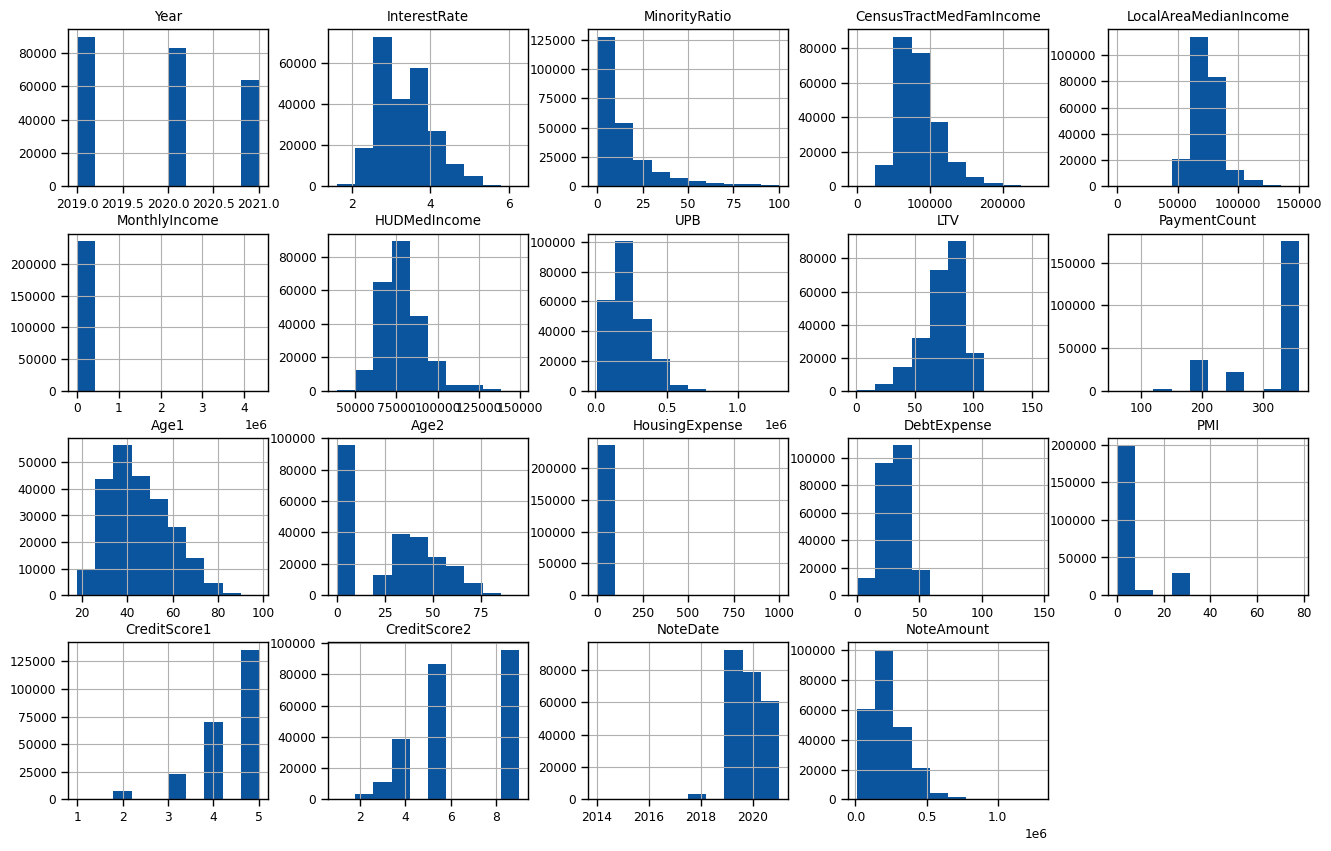

In [49]:
numerical.hist(figsize=(16,10), layout=(4,5));

### Outlier detection and winsorizing



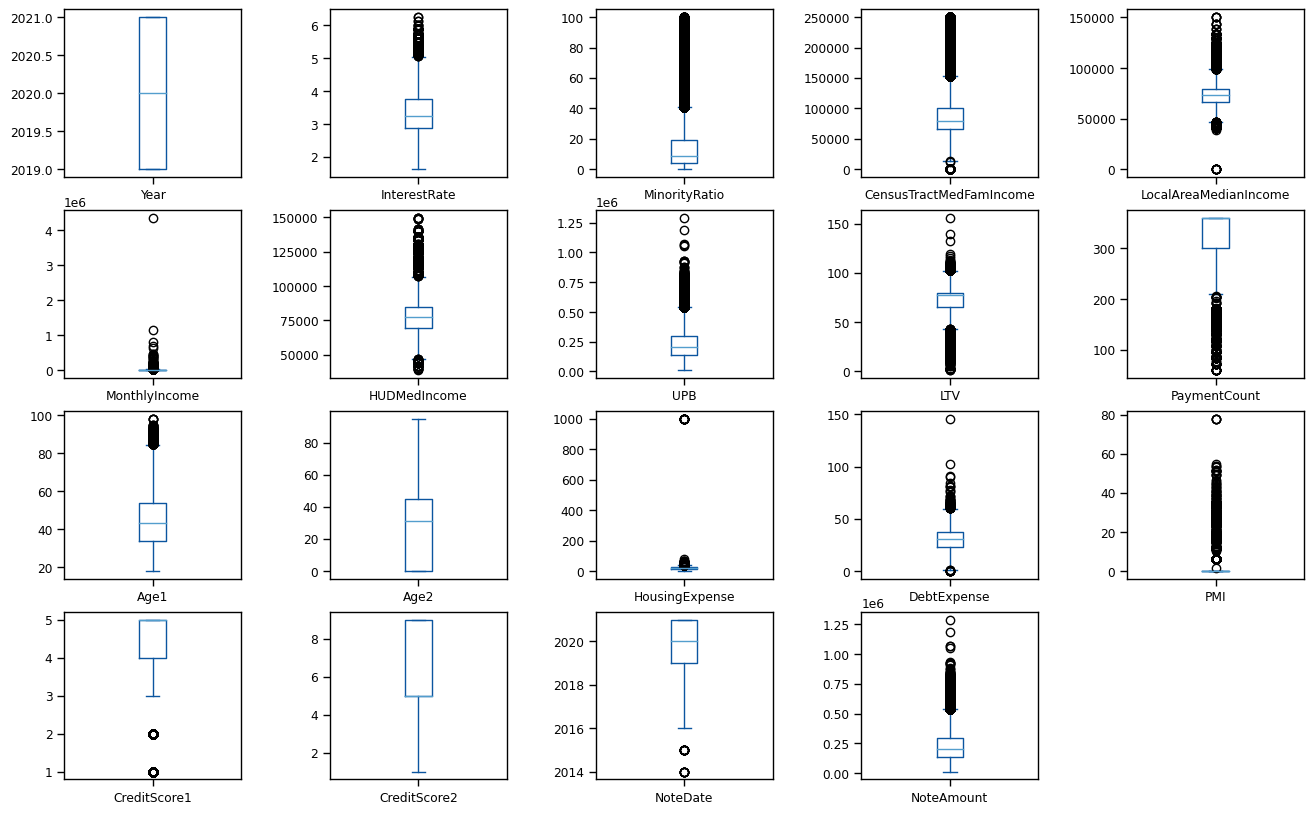

In [50]:
numerical.plot(kind='box', subplots=True, sharey=False, figsize=(16, 10), layout=(4,5))

# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [51]:
print(f'The maximum value of PaymentCount is {numerical.PaymentCount.max()} and it constitutes '\
      f'{int(100*(numerical.PaymentCount ==numerical.PaymentCount.max()).sum() / len(numerical))}% of the observations in the dataset.')

print(f'The minimum value of PMI is {numerical.PMI.min()} and it constitutes '\
      f'{int(100*(numerical.PMI ==numerical.PMI.min()).sum() / len(numerical))}% of the observations in the dataset.')

The maximum value of PaymentCount is 360 and it constitutes 73% of the observations in the dataset.
The minimum value of PMI is 0.0 and it constitutes 84% of the observations in the dataset.


The variable `PaymentCount` represents the Term of the Mortgage in Months, and we will prevent winsorization because of the little meaning it could have and also because of the highly skewed distribution, which will imply that we would lose all information content of the variable.

The variable `PMI` represents the percent of mortgage balance at origination covered by loan level PMI (Private Mortgage Insurance), and it is also highly skewed towards 0. By the same reasoning, modifying this variable will lead to loss of information therefore it will not be subject to winsorization.

### Winsorization
We decide to recode the most extreme values using **winsorization**, in order to obtain a more balanced dataset while keeping the information content of the extreme values.

In [52]:
from scipy.stats.mstats import winsorize

In [53]:
#Outer fences of the variable InterestRate
def fences(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_le, outer_fence_ue

outer_fence_le, outer_fence_ue = fences(numerical, 'InterestRate')
print('Lower end outer fence: ', outer_fence_le)
print('Upper end outer fence: ', outer_fence_ue)

Lower end outer fence:  0.25
Upper end outer fence:  6.375


In [54]:
numerical.InterestRate.describe()

count    236349.000000
mean          3.370581
std           0.651299
min           1.625000
25%           2.875000
50%           3.250000
75%           3.750000
max           6.250000
Name: InterestRate, dtype: float64

In this case, the fences are more extreme than the minimum and maximum observed values. Therefore, no winsorization will occurr. We repeat this process for all numerical variables and perform winsorization on the right or left tails as needed. 

In [55]:
df=pd.DataFrame()

for col in numerical.columns: 

    if col in ['PMI', 'PaymentCount', 'CreditScore1', 'CreditScore2']:
        df[col] = numerical[col]
    
    else:
        outer_fence_le, outer_fence_ue = fences(numerical, col)
    
        if outer_fence_le > numerical[col].min():
            #print('outer_fence_le > numerical.col.min() ')
            if outer_fence_ue < numerical[col].max():
                df[col] = winsorize(numerical[col], 
                                    limits=(percentileofscore(numerical[col],outer_fence_le), (100-percentileofscore(numerical[col],outer_fence_ue))/100), 
                                    inclusive=(False,False), inplace=False)
                print(col + ' winsorized on both sides')
                
            else: 
                df[col] = winsorize(numerical[col], 
                                    limits=(percentileofscore(numerical[col],outer_fence_le), 0), 
                                    inclusive=(False,False), inplace=False)
                print(col + ' winsorized on the left side')
                
        elif outer_fence_ue < numerical[col].max():
            df[col] = winsorize(numerical[col], 
                                limits=(0, (100-percentileofscore(numerical[col],outer_fence_ue))/100), 
                                inclusive=(False,False), inplace=False)
            print(col + ' winsorized on the right side')
            
        else: 
            df[col] = numerical[col]

MinorityRatio winsorized on the right side
CensusTractMedFamIncome winsorized on the right side
LocalAreaMedianIncome winsorized on both sides
MonthlyIncome winsorized on the right side
HUDMedIncome winsorized on the right side
UPB winsorized on the right side
LTV winsorized on both sides
HousingExpense winsorized on the right side
DebtExpense winsorized on the right side
NoteAmount winsorized on the right side


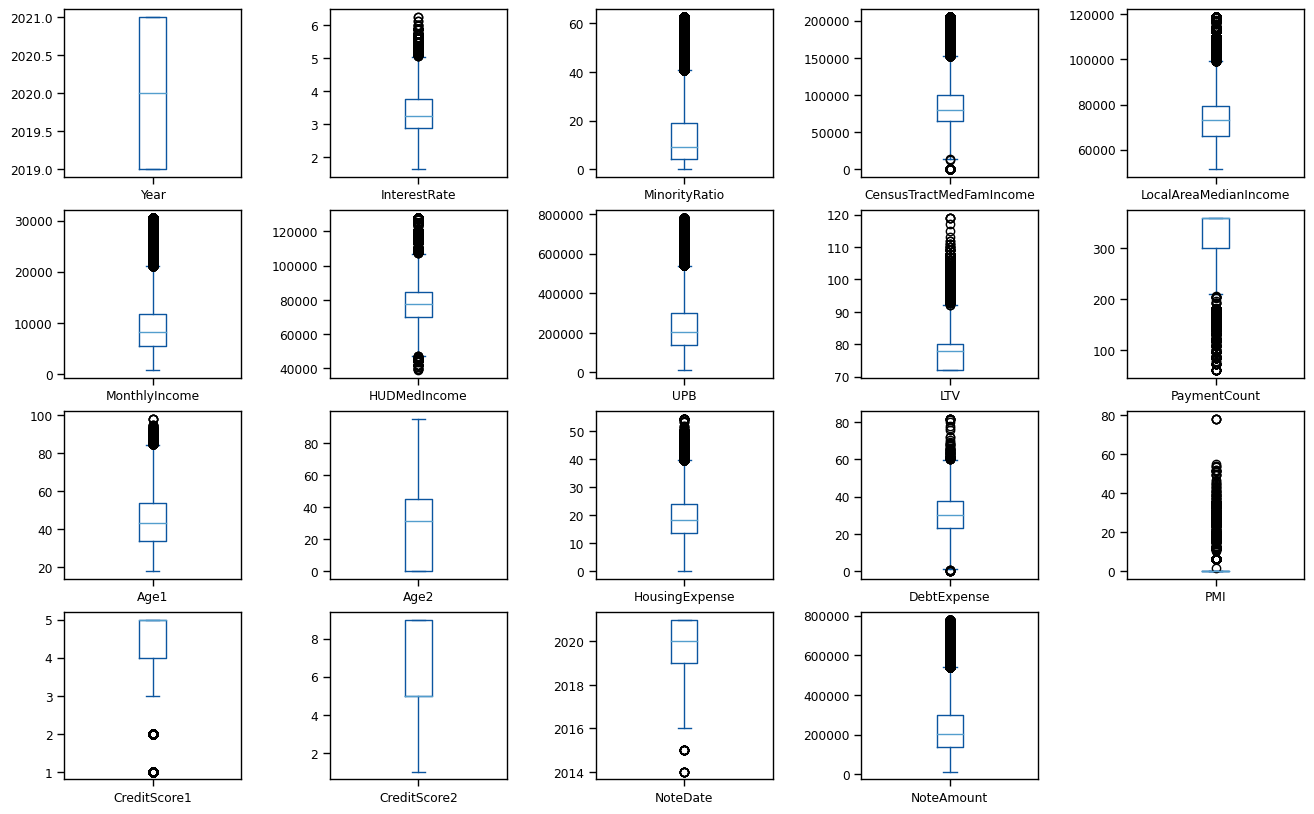

In [56]:
df.plot(kind='box', subplots=True, sharey=False, figsize=(16, 10), layout=(4,5))

# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [57]:
dist_ = df[['InterestRate','NoteDate']]
dist_ = dist_[dist_['NoteDate'] >= 2018]
dist_.sort_values(by='NoteDate', ascending=False, inplace=True)

colors=sns.color_palette("colorblind", as_cmap=False)

In [58]:
dist_

,InterestRate,NoteDate
0,2.750,2021
41685,3.000,2021
41657,2.750,2021
41658,2.750,2021
41659,2.750,2021
...,...,...
184665,4.250,2018
151408,5.250,2018
151409,5.375,2018
184668,4.500,2018


/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/p_/77946ggd5fs5m05m058z3hp40000gn/T/ipykernel_70065/2141864158.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(data=dist_, x="InterestRate", hue="NoteDate", hue_order=[2021,2020,2019,2018],palette=colors,bw_adjust=1.4,
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecate

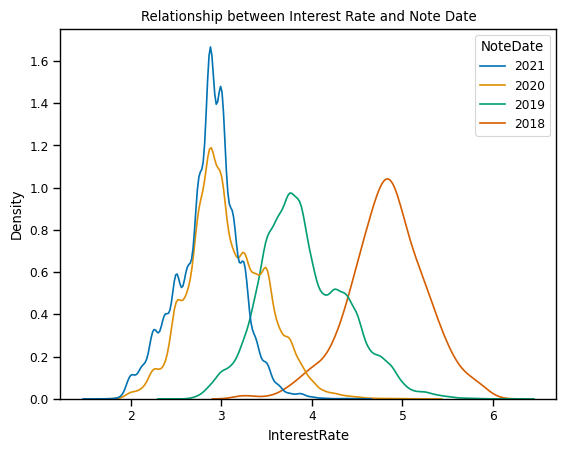

In [59]:
sns.kdeplot(data=dist_, x="InterestRate", hue="NoteDate", hue_order=[2021,2020,2019,2018],palette=colors,bw_adjust=1.4,
            common_norm=False, fill=False).set(title='Relationship between Interest Rate and Note Date')
plt.savefig('int_years.png')
plt.show()

# Correlation Analysis

## INSERISCO SCALING

In [60]:
df

,Year,InterestRate,MinorityRatio,CensusTractMedFamIncome,LocalAreaMedianIncome,MonthlyIncome,HUDMedIncome,UPB,LTV,PaymentCount,Age1,Age2,HousingExpense,DebtExpense,PMI,CreditScore1,CreditScore2,NoteDate,NoteAmount
0,2021,2.750,6.379,91316,85144,11771,92300,352000,80.0,360,27,27,15.93,21.35,0.0,5,5,2021,352000
1,2021,2.250,3.553,100396,85144,5651,92300,139872,72.0,180,53,0,25.60,46.77,0.0,5,9,2021,139872
2,2021,3.000,8.537,87500,91102,9395,95300,208000,80.0,360,36,0,13.45,15.84,0.0,5,9,2021,208000
3,2021,3.000,6.052,114531,91102,5912,95300,228000,80.0,360,33,35,26.64,42.28,0.0,3,3,2020,228000
4,2021,3.000,3.583,119423,91102,4420,95300,170000,73.0,360,43,0,22.92,33.05,0.0,5,9,2021,170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236758,2019,3.875,17.119,54688,69210,3275,70000,133000,95.0,360,71,0,31.88,43.53,30.0,5,9,2019,133000
236759,2019,3.500,5.698,85714,69210,11500,70000,295000,84.0,240,27,32,20.68,27.70,6.0,5,5,2019,295000
236760,2019,3.875,13.887,84821,73964,4298,75200,77250,72.0,360,67,66,18.25,35.93,0.0,5,5,2019,77250
236761,2019,4.625,6.373,73150,69210,6810,70000,207100,95.0,360,49,46,25.12,45.49,30.0,4,4,2019,207100


In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
# scale numerical vars 
ss = StandardScaler()
df_scale = ss.fit_transform(df)
df_scale = pd.DataFrame(df_scale, columns=df.columns)
df_scale.head()

/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated

,Year,InterestRate,MinorityRatio,CensusTractMedFamIncome,LocalAreaMedianIncome,MonthlyIncome,HUDMedIncome,UPB,LTV,PaymentCount,Age1,Age2,HousingExpense,DebtExpense,PMI,CreditScore1,CreditScore2,NoteDate,NoteAmount
0,1.389782,-0.952838,-0.554642,0.203695,0.963066,0.395887,1.117801,0.984893,0.165741,0.570977,-1.331285,0.024876,-0.421006,-0.927313,-0.415085,0.738576,-0.573075,1.403060,0.982591
1,1.389782,-1.720536,-0.743870,0.519259,0.963066,-0.682364,1.117801,-0.724988,-0.860784,-1.970029,0.615119,-1.102259,0.787130,1.719000,-0.415085,0.738576,1.171371,1.403060,-0.726089
2,1.389782,-0.568989,-0.410142,0.071074,1.474587,-0.022728,1.356775,-0.175835,0.165741,0.570977,-0.657530,-1.102259,-0.730849,-1.500924,-0.415085,0.738576,1.171371,1.403060,-0.177322
3,1.389782,-0.568989,-0.576537,1.010503,1.474587,-0.636380,1.356775,-0.014623,0.165741,0.570977,-0.882115,0.358842,0.917064,1.251575,-0.415085,-1.765394,-1.445299,0.201411,-0.016223
4,1.389782,-0.568989,-0.741861,1.180518,1.474587,-0.899248,1.356775,-0.482138,-0.732468,0.570977,-0.133498,-1.102259,0.452300,0.290699,-0.415085,0.738576,1.171371,1.403060,-0.483410


## BACK TO CORRELATION ANALYSIS

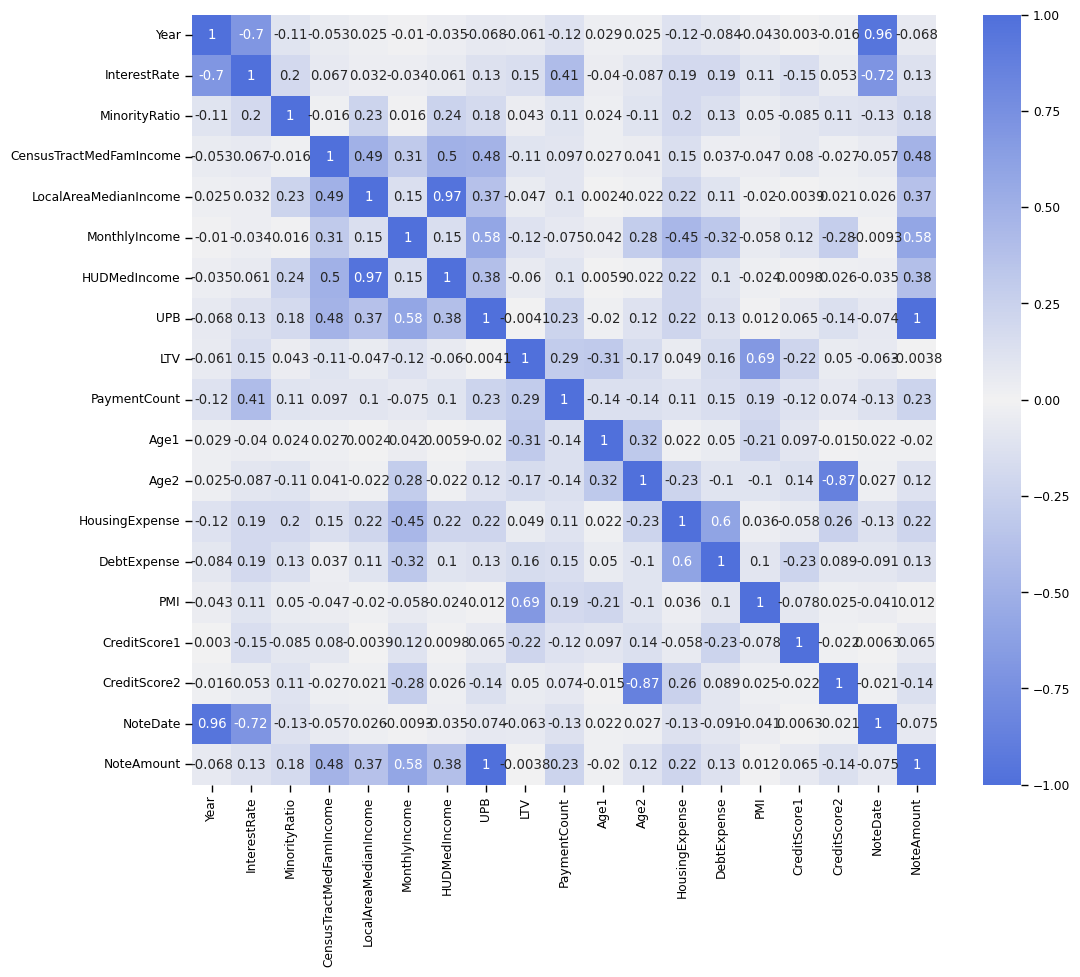

In [63]:
corr=df_scale.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool)) # generate a mask for upper triangle
cmap = sns.diverging_palette(980, 980, as_cmap=True) # configure a custom diverging colormap
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1);

From this matrix we can see some very high correlation values which are due to the fact that some variables present very similar information.

For example, `NoteAmount` refers to the mortgage balance at origination, while `UPB` refers to the amount of unpaid principal balance in whole dollars when acquired by the FHLBank. These variables have a correlation of 0.9997. Therefore, we will exclude one of the two. 

Additionally, a strong correlation of 0.97 can be found between `HUDMedIncome` and `LocalAreaMedianIncome`, which are both measures of the median income in a given area, hence we will have to exclude one of them from our analysis. We will keep `HUDMedIncome` since it presents a higher correlation with our variable of interest `InterestRate`, and it represents the current median income for a family of four for the area as established by the US Department of Housing and Urban Development (HUD).

The same is true for `Year` and `NoteDate`, with a correlation of 0.96. We drop the variable `Year`, indicating the year in which the mortgage was acquired by the Federal Home Loan Bank, and we keep `NoteDate`, the variable indicating the year in which the mortgage was originated.

In [64]:
df_scale['NoteAmount'].equals(df_scale['UPB']), df_scale['NoteAmount'].corr(df_scale['UPB'])

(False, 0.9996520230934474)

In [65]:
df_scale['HUDMedIncome'].equals(df_scale['LocalAreaMedianIncome']), df_scale['HUDMedIncome'].corr(df_scale['LocalAreaMedianIncome'])

(False, 0.9710995456588243)

In [66]:
df_scale['NoteDate'].equals(df_scale['Year']), df_scale['NoteDate'].corr(df_scale['Year'])

(False, 0.9559514707226092)

In [67]:
df_scale.drop(['UPB','LocalAreaMedianIncome','Year'],inplace=True, axis=1)

In [68]:
blues_r_palette = sns.color_palette("Blues_r", as_cmap=True)
custom_diverging_palette = [
    blues_r_palette(0.0),  # The first color from "Blues_r" (most extreme)
    "white",               # White as the middle color
    blues_r_palette(0.0)           # A color for the other extreme
]
sns.set_palette(custom_diverging_palette)

In [69]:
blues_r_cmap = sns.color_palette("Blues_r", as_cmap=False)
print(blues_r_cmap.as_hex())

['#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb', '#dbe9f6']


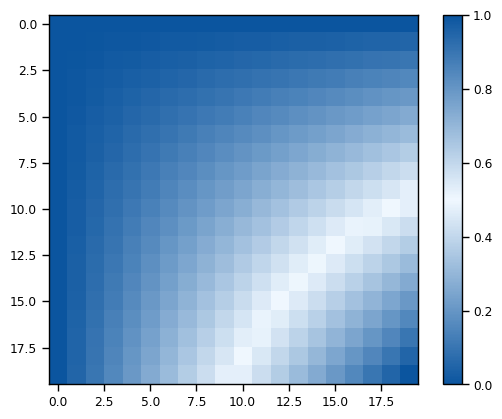

In [70]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Tableau 20 color palette for demonstration
colors = [(11,85,159),(240,248,255), (11,85,159)]
colors = [(e[0] / 255.0, e[1] / 255.0, e[2] / 255.0) for e in colors]

nc = len(colors)
c = np.zeros((3, nc, 3))
rgb = ['red', 'green', 'blue']
for idx, e in enumerate(colors):
    for ii in range(3):
        c[ii, idx, :] = [float(idx) / float(nc - 1), e[ii], e[ii]]

cdict = dict(zip(rgb, c))
cmap = LinearSegmentedColormap('tab20', cdict)

a = np.outer(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
im = plt.imshow(a, cmap=cmap)
plt.colorbar(im)
plt.show()

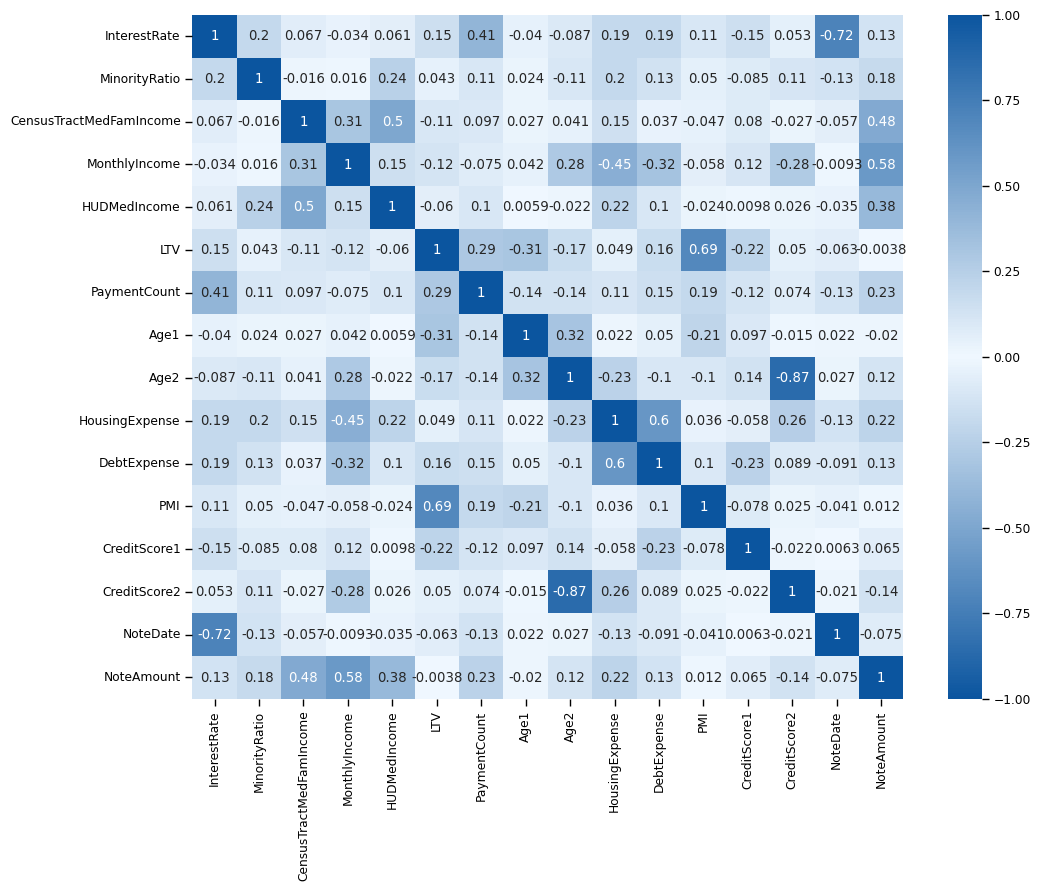

In [71]:
corr=df_scale.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool)) # generate a mask for upper triangle
#cmap = sns.diverging_palette(0.58,0.58,0.87, 0.33, as_cmap=True) # configure a custom diverging colormap
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1);
plt.tight_layout()
f.savefig('corr.png')

After removing these variables, correlation patterns seem to be reasonable. 

##### Dependent variable: `InterestRate`
The variable of interest, `InterestRate`, presents a very strong negative correlation of -0.72 with `NoteDate`, which suggests that for more recent years interest rates have gone down. This is coherent with the macroeconomic trends over the period: as a matter of fact, the FED funds rate has been decreasing over the period considered. 

`InterestRate` and `PaymentCount` are also positively correlated, which can be traced back to the fact that longer-term mortgages are normally associated with higher interest rates.

Interstingly, the third highest value of the correlation coeffiencient between `InterestRate` and the other variables is with `MinorityRaratio`, with a value of 0.2. The value is small, however it indicates that mortgages originated in areas with higher minority ratios present slightly higher interest rates.


##### Other variables
We can identify strong correlation between the age of borrower 1 and the age of borrower 2, which we can explain if we assume that often the second borrower is borrower 1's partner. 

`HousingExpense` and `DebtExpense` present a correlation of 0.6, as we can expect, meaning that higher housing expenses are associated with higher debt expenses. 

Additionally, `MonthlyIncome` presents a positive correlation of 0.58 with `UPB`, and negative correlations with both `HousingExpense` and `DebtExpense`, suggesting that people with lower income tend to borrow less. 

High correlation can also be seen for `LTV` and `PMI`, indicating that for higher Loan-to-Value ratios we can find higher percentages of mortgage balance at origination covered by loan level PMI.

Notably, we have to highlight that `CreditScore1` and `CreditScore2` do not present high correlations with the other variables, not even between the two. 



In [72]:
df

,Year,InterestRate,MinorityRatio,CensusTractMedFamIncome,LocalAreaMedianIncome,MonthlyIncome,HUDMedIncome,UPB,LTV,PaymentCount,Age1,Age2,HousingExpense,DebtExpense,PMI,CreditScore1,CreditScore2,NoteDate,NoteAmount
0,2021,2.750,6.379,91316,85144,11771,92300,352000,80.0,360,27,27,15.93,21.35,0.0,5,5,2021,352000
1,2021,2.250,3.553,100396,85144,5651,92300,139872,72.0,180,53,0,25.60,46.77,0.0,5,9,2021,139872
2,2021,3.000,8.537,87500,91102,9395,95300,208000,80.0,360,36,0,13.45,15.84,0.0,5,9,2021,208000
3,2021,3.000,6.052,114531,91102,5912,95300,228000,80.0,360,33,35,26.64,42.28,0.0,3,3,2020,228000
4,2021,3.000,3.583,119423,91102,4420,95300,170000,73.0,360,43,0,22.92,33.05,0.0,5,9,2021,170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236758,2019,3.875,17.119,54688,69210,3275,70000,133000,95.0,360,71,0,31.88,43.53,30.0,5,9,2019,133000
236759,2019,3.500,5.698,85714,69210,11500,70000,295000,84.0,240,27,32,20.68,27.70,6.0,5,5,2019,295000
236760,2019,3.875,13.887,84821,73964,4298,75200,77250,72.0,360,67,66,18.25,35.93,0.0,5,5,2019,77250
236761,2019,4.625,6.373,73150,69210,6810,70000,207100,95.0,360,49,46,25.12,45.49,30.0,4,4,2019,207100


In [73]:
dist = df[['InterestRate','NoteDate']]
dist = dist[dist['NoteDate'] >= 2018]
colors=sns.color_palette("Blues_r", as_cmap=False)
sns.set_palette(colors)


/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fra/miniconda3/envs/tensorflow/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


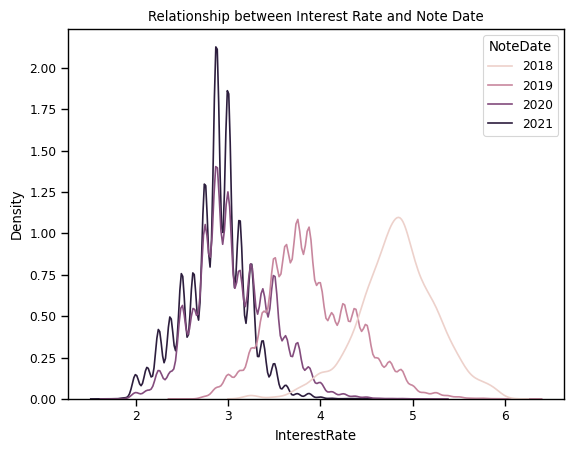

In [74]:
sns.kdeplot(data=dist, x="InterestRate", hue="NoteDate", common_norm=False, fill=False).set(title='Relationship between Interest Rate and Note Date')
plt.show()

In [75]:
numerical = df_scale

In [76]:
print(sns.color_palette("Blues_r").as_hex())

['#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb', '#dbe9f6']


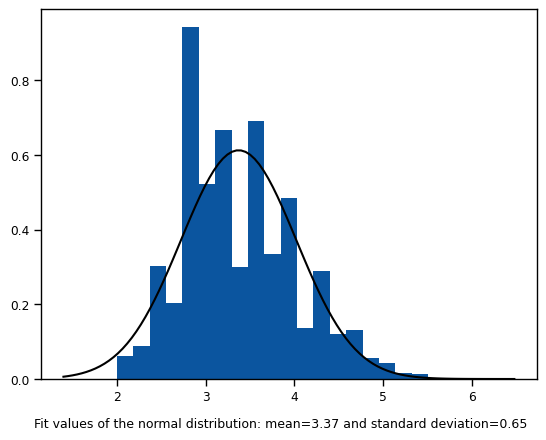

In [83]:
mu, std = norm.fit(data.NoteRatePercent) 
  
# Plot the histogram.
plt.hist(data.NoteRatePercent, bins=25, density=True, alpha=1)#, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth= 1.5)
title = "Interest Rate Distribution"
footnote = "Fit values of the normal distribution: mean={:.2f} and standard deviation={:.2f}".format(mu, std)
#plt.title(title)
plt.figtext(0.5, 0.01, footnote, ha="center", fontsize=9)

plt.savefig('IntRate_Distribution2.png')
plt.show();

## Categorical variables

In [84]:
categorical.columns

Index(['Bank', 'LoanPurpose', 'MortgageType', 'InstType', 'BorrowerCount',
       'FirstTime', 'Gender1', 'Gender2', 'PropertyUsage', 'SelfEmployed',
       'PropertyType', 'HOEPA', 'UnitCount', 'Race1', 'Minority2', 'Race2',
       'CensusTractIdentifier', 'AreaCode', 'County', 'State', 'Minority'],
      dtype='object')

In [85]:
categorical=categorical.rename(columns={
    'Bank': 'Bank',
    'LoanPurposeType': 'LoanPurpose', 
    'MortgageType':'MortgageType',
    'MortgageLoanSellerInstType':'InstType',
    'BorrowerCount':'BorrowerCount',
    'BorrowerFirstTimeHomebuyer':'FirstTime',
    'Borrower1GenderType':'Gender1',
    'Borrower2GenderType':'Gender2', 
    'PropertyUsageType':'PropertyUsage',
    'EmploymentBorrowerSelfEmployed':'SelfEmployed',
    'PropertyType':'PropertyType',
    'HOEPALoanStatusType':'HOEPA',
    'PropertyUnitCount':'UnitCount',
    'Borrower1Race1Type':'Race1',
     'Borrower2Minority':'Minority2',
     'Borrower2Race1Type':'Race2',
     'CensusTractIdentifier':'CensusTractIdentifier',
     'CoreBasedStatisticalAreaCode':'AreaCode',
     'FIPSCountyCode':'County',
     'FIPSStateNumericCode':'State',
     'Minority':'Minority'
         })

In [86]:
categorical=categorical.astype("category")

In [87]:
categorical.describe()

,Bank,LoanPurpose,MortgageType,InstType,BorrowerCount,FirstTime,Gender1,Gender2,PropertyUsage,SelfEmployed,...,HOEPA,UnitCount,Race1,Minority2,Race2,CensusTractIdentifier,AreaCode,County,State,Minority
count,236349,236349,236349,236349,236349,236349,236349,236349,236349,236349,...,236349,236349,236349,236349,236349,236349.0,236349,236349,236349,236349
unique,10,3,4,3,6,2,4,5,2,2,...,3,4,6,3,8,15990.0,863,249,52,3
top,Chicago,6,0,1,2,0,1,2,1,0,...,2,1,5,White,5,9601.0,Missing,31,55,White
freq,59823,80678,225851,235357,140137,189715,163554,107631,229143,184768,...,235322,234452,208482,125638,125638,1739.0,39416,6060,28613,208482


In [ ]:
categorical_features = categorical.columns
fig, ax = plt.subplots(2, 1+len(categorical_features)//2, figsize=(20,7), tight_layout=True)

for i, categorical_feature in enumerate(categorical_features[:1+len(categorical_features)//2]):
    categorical[categorical_feature].value_counts().sort_index().plot(kind="bar", ax=ax[0,i]).set_title(categorical_feature)
for i, categorical_feature in enumerate(categorical_features[1+len(categorical_features)//2:]):
    categorical[categorical_feature].value_counts().sort_index().plot(kind="bar", ax=ax[1,i]).set_title(categorical_feature)

From this graph, it is clear that some of the variables will need to be recoded or excluded for the analysis since they are extremely unbalanced.
We will now explore them more in detail.

### Removing columns with low variance (<0.15)

Columns with extremely low variance will be removed because they don't have any relevant informational content. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# preparation of data for variance analysis
df = categorical.copy()
enc = OrdinalEncoder()
df[['Bank','Minority','Minority2']] = enc.fit_transform(df[['Bank','Minority','Minority2']])
df = df.replace('Missing', np.NaN)

In [ ]:
sel = VarianceThreshold(threshold=(.15))
X_sel = sel.fit_transform(df)
print('The removed features are: '+str(set(categorical.columns) - set (sel.get_feature_names_out())))
categorical_enc = pd.DataFrame(X_sel, columns=sel.get_feature_names_out())
categorical = categorical[sel.get_feature_names_out()]




### Gender variables:

**`Gender1`**
Numeric code indicating the sex of the first or primary borrower. 
- 1=Male, 
- 2=Female, 
- 3=Information not provided by borrower, 
- 4=Not Applicable (First or primary borrower is an institution, corporation or partnership), 
- 6=Borrower selected both male and female

In [ ]:
categorical['Gender1'].value_counts().sort_index()

In [ ]:
categorical['Gender1']=categorical['Gender1'].apply(lambda x: 3 if x==6 else x).astype("category")
categorical['Gender1'].value_counts().sort_index()

**`Gender2`**
Numeric code indicating the sex of the co-borrower. 
- 1=Male, 
- 2=Female, 
- 3=Information not provided by borrower, 
- 4=No Co-Borrower, 
- 5=Not Applicable (First or primary borrower is an institution, corporation or partnership), 
- 6=Borrower selected both male and female

In [ ]:
categorical['Gender2'].value_counts().sort_index()

In [ ]:
categorical['Gender2']=categorical['Gender2'].apply(lambda x: 3 if x==6 else x).astype("category")
categorical['Gender2'].value_counts().sort_index()

## BorrowerCount
Variable representing the number of borrowers for a single loan. We group into 2 categories:
- 1: 1 borrower
- 2: 2 or more borrowers

In [ ]:
categorical['BorrowerCount'].value_counts().sort_index()

In [ ]:
categorical['BorrowerCount']=categorical['BorrowerCount'].apply(lambda x: 2 if x in (3,4,5,6) else x).astype("category")
categorical['BorrowerCount'].value_counts().sort_index()

## InstType

Type of Institution from which the FHLBank acquired the mortgage. 
- 01=Insured depository institution, 
- 02=Housing Associate, 
- 03=Insurance Company, 
- 04=Non-Federally Insured CU, 
- 05=Non-Depository CDFI, 
- 06=Other FHLBank, 
- 09=Other

In [ ]:
categorical['InstType'].value_counts().sort_index()

The information content of this variable is extremely little and in this case it would be meaningful to exclude it from the analysis.

In [ ]:
categorical.drop(['InstType'], inplace=True, axis=1)

### Geographical Information



In [ ]:
categorical[['CensusTractIdentifier', 'AreaCode', 'County', 'State']].describe()

These variables present too much variance, and for our analysis we would need to use one hot encoding. Therefore, we will only keep in our analysis the State variable, to be later transformed with one hot encoding.



In [ ]:
categorical.drop(['CensusTractIdentifier', 'AreaCode', 'County'], inplace=True, axis=1)
print(f'We retain {len(categorical.columns)} categorical variables for our analysis.')

## Summary of categorical variables

In [ ]:
categorical_features = categorical.columns
fig, ax = plt.subplots(2, 7, figsize=(20,7), tight_layout=True)
for i, categorical_feature in enumerate(categorical_features[:7]):
    categorical[categorical_feature].value_counts().sort_index().plot(kind="bar", ax=ax[0,i]).set_title(categorical_feature)
for i, categorical_feature in enumerate(categorical_features[7:]):
    categorical[categorical_feature].value_counts().sort_index().plot(kind="bar", ax=ax[1,i]).set_title(categorical_feature)

# One Hot Encoding

We proceed with the one hot encoding of the categorical variables that do not express a sort of order and that are not dummy variables.

In [ ]:
categorical.columns

In [ ]:
one_hot = ['Bank', 'LoanPurpose', 'MortgageType', 'Gender1', 'Gender2', 'PropertyType', 
           'Race1', 'Minority2', 'Race2', 'State', 'Minority']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(min_frequency=5000, sparse_output=False)
encoded = enc.fit_transform(categorical[one_hot])
print(enc.infrequent_categories_)

In [ ]:
encoded = pd.DataFrame(encoded, columns=enc.get_feature_names_out(), index= categorical.index)
encoded.head()

# Cleaned Data
    

In [104]:
assert len(categorical) == len(encoded)

In [105]:
pd.testing.assert_index_equal(categorical.index,encoded.index, check_names=False)

In [106]:
categorical_encoded = pd.merge(categorical.drop(one_hot, axis=1),encoded, left_index=True, right_index=True)
categorical_encoded.head()

,BorrowerCount,FirstTime,SelfEmployed,Bank_Boston,Bank_Chicago,Bank_Cincinnati,Bank_Dallas,Bank_Des Moines,Bank_Indianapolis,Bank_Pittsburgh,...,State_29,State_31,State_39,State_42,State_48,State_55,State_infrequent_sklearn,Minority_Minority,Minority_Missing,Minority_White
0,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [107]:
pd.testing.assert_index_equal(numerical.index, categorical_encoded.index, check_names=False)

AssertionError: Index are different

Index values are different (99.32219 %)
[left]:  RangeIndex(start=0, stop=236349, step=1)
[right]: Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       236753, 236754, 236755, 236756, 236757, 236758, 236759, 236760, 236761,
       236762],
      dtype='int64', length=236349)

### Saving csv (with and without encoding)

In [ ]:
clean = pd.merge(numerical, categorical, left_index=True, right_index=True)
clean['Borrower2Dummy'] = data['Borrower2Dummy']
clean.head()

In [ ]:
#clean.to_csv('../analysis/clean2.csv')

In [ ]:
numerical_columns = numerical.columns
#pd.DataFrame(numerical_columns).to_csv('../analysis/numerical.csv')

In [ ]:
categorical_columns = list(categorical.columns)+['Borrower2Dummy']
#pd.DataFrame(categorical_columns).to_csv('../analysis/categorical.csv')

In [ ]:
# with encoded variables
clean_enc = pd.merge(numerical,categorical_encoded, left_index=True, right_index=True)
clean_enc['Borrower2Dummy'] = data['Borrower2Dummy']
clean_enc.head()

In [ ]:
categorical_columns_enc = list(categorical_encoded.columns)+['Borrower2Dummy']
#pd.DataFrame(categorical_columns_enc).to_csv('../analysis/categorical_enc.csv')

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(clean_enc, test_size=0.2, random_state=7, shuffle=True, stratify=None)

In [ ]:
train

In [ ]:
test

In [ ]:
#pd.DataFrame(train).to_csv('../analysis/train.csv')
#pd.DataFrame(test).to_csv('../analysis/test.csv')

# Bivariate Analysis: Credit Score for Minority vs Non-minority

- MAYBE THIS CAN BE A FUNCTION IF I NEED THE SAME ANALYSIS FOR OTHER VAR

In [ ]:
dist = data[['NoteRatePercent','Minority']]
#dist = dist[dist['NoteDate'] >= 2018]
#dist.sort_values(by='NoteDate', ascending=False, inplace=True)

colors=sns.color_palette("colorblind", as_cmap=False)

In [ ]:
dist

In [ ]:
sns.kdeplot(data=dist, x="NoteRatePercent", hue="Minority",  bw_adjust=1.2,
            palette=colors, common_norm=False, fill=False)#.set(title='Relationship between Interest Rate and Note Date')
plt.xlabel("InterestRate")  # Set the x-label
#plt.ylabel("")  # Remove the y-label
#plt.yticks([])  
plt.savefig('minority_int_kde.png')
plt.show()

## GENDER


In [ ]:
namevar = 'Borrower1GenderType'

In [ ]:
dist = data[['NoteRatePercent',namevar]]

In [ ]:
sns.kdeplot(data=dist, x="NoteRatePercent", hue=namevar,  bw_adjust=1.2,
            palette=colors, common_norm=False, fill=False)#.set(title='Relationship between Interest Rate and Note Date')
plt.xlabel("InterestRate")  # Set the x-label
#plt.ylabel("")  # Remove the y-label
#plt.yticks([])  
#plt.savefig('minority_int_kde.png')
plt.show()

# OLD

In [ ]:
clean.CreditScore1.value_counts().sort_index().plot(kind='bar', figsize=(5,3.5),
                                    title='Credit Score', xlabel='', ylabel='Count', rot=0);

In [ ]:
clean.CreditScore1.value_counts()

In [166]:
clean

NameError: name 'clean' is not defined

In [ ]:
df = pd.concat([clean.Minority, clean.CreditScore1], axis=1)
sns.kdeplot(data=clean, x='CreditScore1', hue='Minority');

In [107]:
all_ = pd.crosstab(clean.CreditScore1, clean.Minority,margins=True)['All']
ct = pd.crosstab(clean.CreditScore1, clean.Minority).divide(all_,axis=0).dropna()
ct 

Minority,Min,Missing,White
CreditScore1,,,
1,0.184615,0.069231,0.746154
2,0.091033,0.062772,0.846196
3,0.074555,0.072008,0.853436
4,0.058617,0.067805,0.873578
5,0.039400,0.067006,0.893594


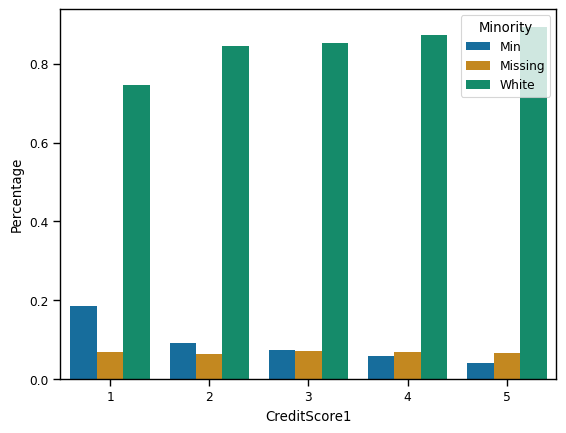

In [108]:
# analysis of distribution of minority categories with credit score categories
mino = pd.DataFrame(ct.Min).rename({'Min':'Percentage'}, axis=1)
mino['Minority']='Min'
NP = pd.DataFrame(ct.Missing).rename({'Missing':'Percentage'}, axis=1)
NP['Minority']='Missing'
White = pd.DataFrame(ct.White).rename({'White':'Percentage'}, axis=1)
White['Minority']='White'
ct2 = pd.concat([mino, NP,White], axis=0).reset_index().rename({'index':'CreditScore1'}, axis=1)

sns.barplot(x='CreditScore1',y='Percentage',hue='Minority',data=ct2);

We can see that the striking majority of observations in all credit score categories is white. However, we can observe that the percentage of minority borrowers declines for higher credit score categories. This is important for further analyses later on.  

First results, no prediction (vedere BERG PARTE 2. Empirical Results ):

	- UNIVARIATE RESULTS: explore difference in means of numerical variables across different levels of credit scores (2.1)
	
	- Explore associations between variables:
		○ In the next step, we report measures of association between the credit bureau score, the digital footprint variables, and control variables (Age, Gender, Order amount, monthly date, and type of the purchase item), to assess whether the digital footprint variables are correlated with the credit bureau score and among each other, or whether they provide independent information 
See table 3![image.png](attachment:image.png)

In [109]:
# mi serve ? 
#numerical.drop('CreditScore2', axis='columns').groupby('CreditScore1').mean()

In [110]:
def create_and_clean_crosstab(dataframe, var1, var2='CreditScore1', normalize='index'):
    #values_var1 = dataframe[var1].unique()
    values_var2 = dataframe[var2].unique()
    cross_tab = pd.crosstab(dataframe[var1], dataframe[var2], normalize=normalize)

    long_cross_tab = pd.DataFrame()
    for value in values_var2:
        cross_tab0 = pd.DataFrame(cross_tab[value])
        cross_tab0['CreditScore']=value
        cross_tab0 = cross_tab0.rename(columns={value:'percentage'})

        long_cross_tab = pd.concat([long_cross_tab, cross_tab0])
        
    long_cross_tab = long_cross_tab.sort_values(var1)
    long_cross_tab = long_cross_tab.reset_index()
    return long_cross_tab

def bar_plot_cross_tab(cross_tab, var1, var2='percentage', order_categories = None):
    cross_tab = cross_tab.astype({'CreditScore':str})
    sns.barplot(data=cross_tab, x=var1, y=var2, hue='CreditScore', hue_order=['1','2','3','4','5'], estimator=sum, errorbar=None)

In [111]:
ct_sex = create_and_clean_crosstab(clean, 'Gender1', 'CreditScore1')
#ct_sex

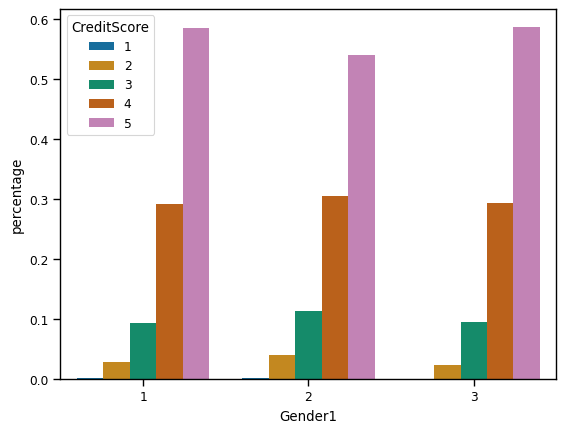

In [112]:
bar_plot_cross_tab(ct_sex, 'Gender1')

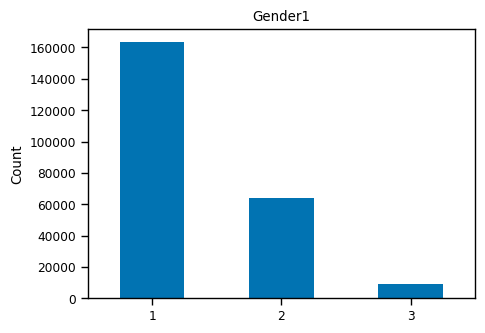

In [113]:
#data.Borrower1GenderType.plot()
clean['Gender1'].value_counts().sort_index().plot(kind='bar', figsize=(5,3.5),
                                                    title='Gender1', xlabel='', ylabel='Count', rot=0);

resampling
synthetic
doing nothing